# Building Image Denoising Autoencoder in Keras
*The aim of this Project is to build a denoising autoencoder (DAE) to deal with CIFAR10 images*

<hr style="height:1px;border:none;color:#333;background-color:#333;" />

## Preparation

*Standard libraries*

In [436]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

*Import tensorflow and check GPU support*

In [437]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Utilities

*Calculates image to image errors across the entire collection*

In [438]:
def rmse_images(images1, images2):
    return math.sqrt(np.square(np.subtract(images1, images2)).mean())

def mae_images(images1, images2):
    return np.abs(np.subtract(images1, images2)).mean()

*Plotting images*

In [439]:
def plot_images(ims, xsize=6, ysize=6, cols=1, interp=False, titles=None):
    # Drop channel for B&W images
    if type(ims[0]) is np.ndarray:
        if (ims.shape[-1] != 3):
            ims = ims[:,:,:,0]
    
    # Calculate the number of rows
    rows=len(ims)//cols if len(ims) % cols == 0 else len(ims)//cols + 1
    
    # Plot a grid of images
    f = plt.figure(figsize=(xsize, ysize))
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

*Collect history*

In [440]:
# Initiates collections of model performance
def start_hist():
    return {}

# Adds more performance indicators to history
def collect_hist(accum_hist, next_hist):
    # Get all keys
    keys = list(next_hist.keys())
    for k in keys:
        if k in accum_hist:
            accum_hist[k].extend(next_hist[k])
        else:
            accum_hist[k] = next_hist[k]
    return accum_hist

*Plotting history*

In [441]:
def plot_hist(h, xsize=6, ysize=5):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    
    # Get training and validation keys
    ks = list(h.keys())
    n2 = math.floor(len(ks)/2)
    train_keys = ks[0:n2]
    valid_keys = ks[n2:2*n2]
    
    # summarize history for different metrics
    for i in range(n2):
        plt.plot(h[train_keys[i]])
        plt.plot(h[valid_keys[i]])
        plt.title('Training vs Validation '+train_keys[i])
        plt.ylabel(train_keys[i])
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.draw()
        plt.show()
    
    return

## Data

*CIFAR10 data set*

In [442]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model

# Data parameters
img_rows, img_cols, img_ch = 32, 32, 3

num_classes = 10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# the data, shuffled and split between train and test sets
(x_train, _), (x_test, _) = cifar10.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Reshape images for processing
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, img_ch)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, img_ch)
input_shape = (img_rows, img_cols, img_ch)

*Set your noise factor (suggested range 0.1-0.5)*

In [443]:
noise_factor = 0.1

*Inject noise into all images*

In [444]:
# Noisy images
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


*Plot original "clean" images*

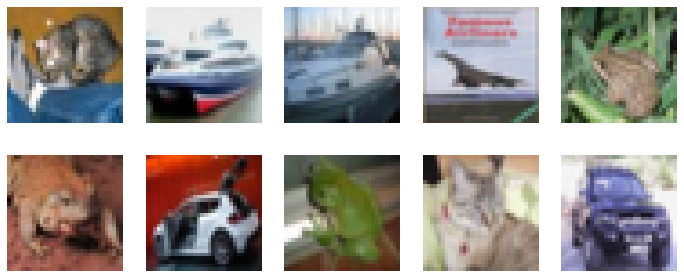

In [445]:
plot_images(x_test[0:10], cols=5, xsize=12, ysize=5)

*Plot noisy images, which need to be denoised*

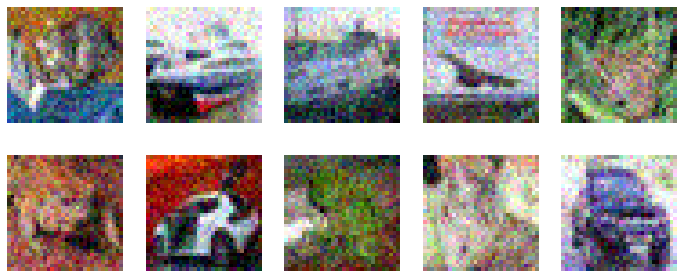

In [446]:
plot_images(x_test_noisy[0:10], cols=5, xsize=12, ysize=5)

## Building a denoising autoencoder (DAE)
***Note that building autoencoder exceeds capabilities of <font color='blue'>sequential</font> models.<br>
Instead we must use <font color='blue'>functional</font> models, which can be arranged in arbitrary ways.***

*Build a simple DAE - note that this is a functional model, not a simple sequence*

## Dae_model_1

In [447]:
def dae_model_1(input_shape, name='dae_1'):
    input_img = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), padding='same')(input_img) # activation='relu'
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(32, (3, 3), padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # at this point the representation is (7, 7, 32)

    x = Conv2D(32, (3, 3), padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded, name=name)
    autoencoder.summary()
    return encoded, decoded, autoencoder

## Dae_model_2

In [448]:
# Your model or models can go here, e.g. with regularisation layers between Conv2D and MaxPooling2D:
#   BatchNormalization to prevent weight going very large or very small
#   LeakyReLU to ensure that weights do not get stuck in backpropagation
def dae_model_2(input_shape, name='dae_1'):
    input_img = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), padding='same')(input_img) # activation='relu'
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=.001)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=.001)(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # at this point the representation is (8, 8, 32)

    x = Conv2D(32, (3, 3), padding='same')(encoded)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=.001)(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=.001)(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded, name=name)
    autoencoder.summary()
    return encoded, decoded, autoencoder


## Dae_model_3

In [449]:
# Model 3
def dae_model_3(input_shape, name='dae_1'):
    input_img = Input(shape=input_shape)

    x = Conv2D(32, (3, 3), padding='same')(input_img) # activation='relu'
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=.001)(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=.001)(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=.001)(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)    

    # at this point the representation is (4, 4, 32)

    x = Conv2D(32, (3, 3), padding='same')(encoded)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=.001)(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), padding='same')(encoded)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=.001)(x)
    x = UpSampling2D((2, 2))(x)    

    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=.001)(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded, name=name)
    autoencoder.summary()
    return encoded, decoded, autoencoder


## Dae_model_4

In [450]:
# Model 4
from keras.layers import Conv2DTranspose, BatchNormalization, add, LeakyReLU
from keras.optimizers import Adam
from keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, UpSampling2D


def dae_model_4(input_shape, name='dae_4'):
    input_img = Input(shape=input_shape)
    
    # Encoder 
    x = Conv2D(32, 3, activation='relu', padding='same')(input_img)
    x = BatchNormalization()(x)
    x = MaxPool2D()(x)
    x = Dropout(0.5)(x)
    skip = Conv2D(32, 3, padding='same')(x) # skip connection for decoder
    x = LeakyReLU()(skip)
    x = BatchNormalization()(x)
    x = MaxPool2D()(x)
    x = Dropout(0.5)(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    encoded = MaxPool2D()(x)

    # Decoder
    x = Conv2DTranspose(64, 3,activation='relu',strides=(2,2), padding='same')(encoded)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv2DTranspose(32, 3, activation='relu',strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv2DTranspose(32, 3, padding='same')(x)
    x = add([x,skip]) # adding skip connection
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    decoded = Conv2DTranspose(3, 3, activation='sigmoid',strides=(2,2), padding='same')(x)
    autoencoder = Model(input_img, decoded, name=name)
    autoencoder.summary()
    return encoded, decoded, autoencoder    

# Model Parameters

In [451]:
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, RMSprop, Adadelta, Adam, Nadam

# Run settings, you may wish to learn incrementally a number of epochs at a time
# batch = 256
# epochs = 20

batch = 128
epochs = 100

# Set up your callbacks
log_dir = '/tmp/autoencoder/dae-simple-1'
callbacks = [# TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True, 
             # embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None,
             # profile_batch = 100000000),
             EarlyStopping(monitor='val_loss', patience=20, verbose=0)]

# Define optimisers, only one will be used
opt_sgd = SGD(lr=0.01, momentum=0.0, nesterov=False) # SGD
opt_sgd_2 = SGD(lr=0.05, momentum=0.1, nesterov=False)
opt_rmsprop_1 = RMSprop(lr=0.005, rho=0.95, momentum=0.01, epsilon=1e-07)
opt_rmsprop_2 = RMSprop(lr=0.01, rho=0.9, decay=0.1, epsilon=1e-07)
opt_adadelta_1 = Adadelta(lr=0.001, rho=0.95, epsilon=1e-07)
opt_adadelta_2 = Adadelta(lr=0.05, rho=0.99, epsilon=1e-07)
opt_adam_1 = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)  # ADAM
opt_adam_2 = Adam(lr=0.005, beta_1=0.85, beta_2=0.999, epsilon=1e-07)
opt_nadam_1 = Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07) # NADAMS
opt_nadam_2 = Nadam(lr=0.001, beta_1=0.7, beta_2=0.95, epsilon=1e-07)


*Build a specific model and compile it*

In [452]:
# Start collecting history, in case we train the model iteratively
ae_hist = start_hist()

# Select the model defined above and compile it
encoded, decoded, autoencoder = dae_model_4(input_shape, name='Simple_DAE')
autoencoder.compile(optimizer=opt_adam_2, loss='binary_crossentropy')

Model: "Simple_DAE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_109 (Conv2D)             (None, 32, 32, 32)   896         input_27[0][0]                   
__________________________________________________________________________________________________
batch_normalization_88 (BatchNo (None, 32, 32, 32)   128         conv2d_109[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_49 (MaxPooling2D) (None, 16, 16, 32)   0           batch_normalization_88[0][0]     
_________________________________________________________________________________________

*Fit the model*

*Note that unless the model has been rebuilt from scratch, the training will simply continue.*

In [453]:
# Fit the model and collect more performance indicators
perform_indics = autoencoder.fit(x_train_noisy, x_train,
                epochs=epochs,
                batch_size=batch,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=callbacks)

# Add performance history
ae_hist = collect_hist(ae_hist, perform_indics.history)

# ae_hist.to_frame.to_csv("ae_hist.csv")

Epoch 1/100
391/391 [==============================] - 4s 11ms/step - loss: 0.5635 - val_loss: 0.5717
Epoch 2/100
391/391 [==============================] - 4s 9ms/step - loss: 0.5587 - val_loss: 0.5589
Epoch 3/100
391/391 [==============================] - 4s 9ms/step - loss: 0.5582 - val_loss: 0.5558
Epoch 4/100
391/391 [==============================] - 4s 9ms/step - loss: 0.5580 - val_loss: 0.5563
Epoch 5/100
391/391 [==============================] - 4s 9ms/step - loss: 0.5578 - val_loss: 0.5548
Epoch 6/100
391/391 [==============================] - 4s 9ms/step - loss: 0.5575 - val_loss: 0.5561
Epoch 7/100
391/391 [==============================] - 4s 9ms/step - loss: 0.5575 - val_loss: 0.5554
Epoch 8/100
391/391 [==============================] - 4s 9ms/step - loss: 0.5574 - val_loss: 0.5547
Epoch 9/100
391/391 [==============================] - 4s 9ms/step - loss: 0.5573 - val_loss: 0.5550
Epoch 10/100
391/391 [==============================] - 4s 9ms/step - loss: 0.5571 - val_l

Plot training performance (will show only the last training run)

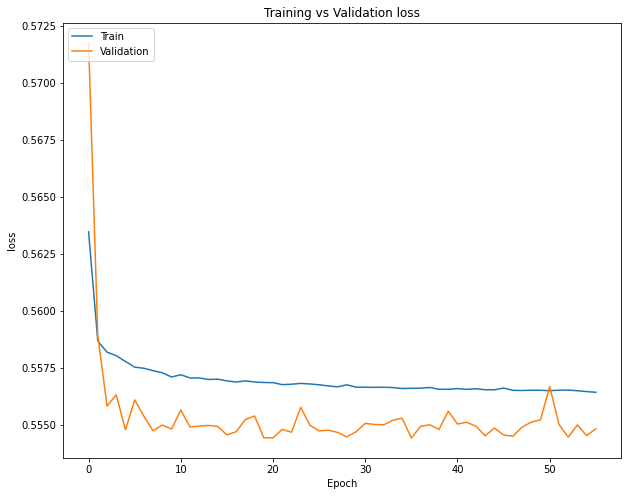

In [454]:
plot_hist(ae_hist, xsize=10, ysize=8)

 ## Let's see if we could now recover the original images from noise

In [455]:
# encode and decode some images from the test set
decoded_noisy_imgs = autoencoder.predict(x_test_noisy)

*Original images*

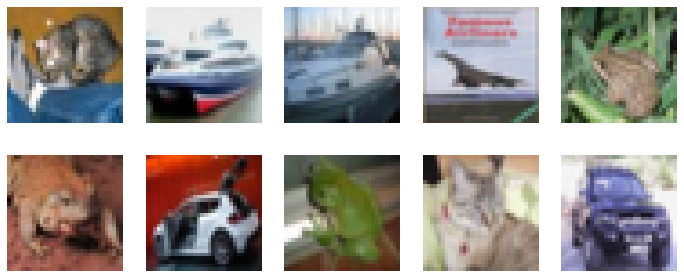

In [456]:
plot_images(x_test[0:10], cols=5, xsize=12, ysize=5)

*Images with injected noise*

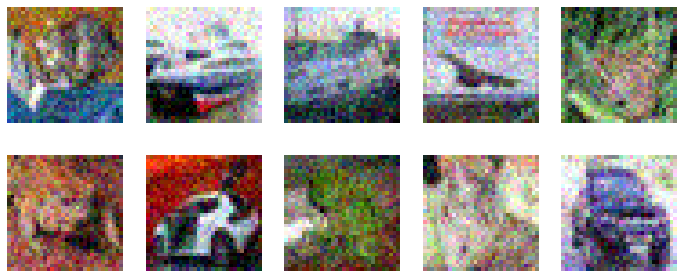

In [457]:
plot_images(x_test_noisy[0:10], cols=5, xsize=12, ysize=5)

*Denoised images*

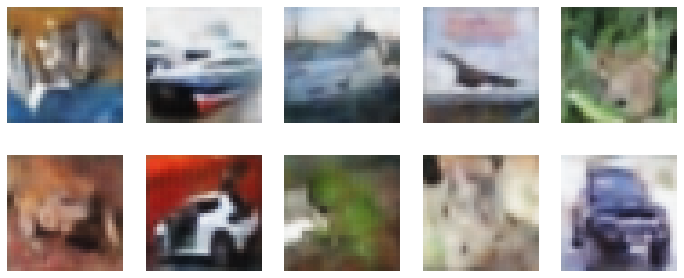

In [458]:
plot_images(decoded_noisy_imgs[0:10], cols=5, xsize=12, ysize=5)

*Calculate DAE error*

In [459]:
print('Original vs noisy MAE:\t\t', round(mae_images(x_test, x_test_noisy), 5))
print('Original vs denoised MAE:\t', round(mae_images(x_test, decoded_noisy_imgs), 5))

Original vs noisy MAE:		 0.07647
Original vs denoised MAE:	 0.03708


<br>**All done! The report follows.**
<hr style="height:1px;border:none;color:#333;background-color:#333;" />

# DAE models, experiments and their results

## Analysis and recommendation


<br>


**Four** Denoising Autoencoders (DAE) models have been built to deal with CIFAR10 images. 28 Experiments have been conducted on these four models combined. It was observed that adding Batch Normalization function and replacing Relu with Leaky Relu function has significantly improved the results.
Also, in most of the experiments increase in the number of Batch Size and Epochs helped increased the clarity of the images. Moreover, Adam and Nadam optimizers helped in reducing the errors. Lastly, Model 2 and Model 3 were providing the best results.

**Strength of the Selected Models:**

In our selected Models, Batch Normalization and LeakyRelu Activation function are included which helps in stabilizing the learning process and thus reducing the number of epochs required to train the model. Moreover, these models would help in saving both time and money as these would take less time to generate the same results as experimented with other models.

**Weakness of the Selected Models:**

These Models still needs further improvement in order to denoise the images with a noise factor of 0.3. Also, the dropout factor has not been added into these models which prevents the problem of overfitting.

**Recommendations**

Model 2 and Model 3 would be recommended as a denoising solution because it incorporates all the necessary functions such as Batch Normalization, Leaky Relu activation function. Moreover, in model 3 an extra layer has been added which helped in improving the model results.


## Summary of experimental results

*Performance is measured as MAE (pixel by pixel difference in RBG channels) comparing the original clean images against images with noise (Noise MAE) and denoised images (Denoised MAE).*

| Model# | Run# | Noise | Batch | Epochs/Stopped | Optimiser | Noisy MAE | Denoised MAE |
| :- | :-: | :-: | :-: | :-: | :- | -: | -: |
| dae_model_1 | 1 | 0.3 | 128 | 20/20 | SGD(lr=0.01, momentum=0.0, nesterov=False) | 0.20259 | 0.09295 |
| dae_model_1 | 2 | 0.3 | 256 | 30/30 | SGD(lr=0.01, momentum=0.0, nesterov=False) | 0.20256 | 0.08709 |
| dae_model_1 | 3 | 0.3 | 512 | 30/30 | Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07) | 0.20255 | 0.07029 |
| dae_model_1 | 4 | 0.3 | 512 | 40/40 | Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07) | 0.20257 | 0.06833 |
| dae_model_1 | 5 | 0.3 | 512 | 42/80 | Adam(lr=0.005, beta_1=0.85, beta_2=0.999, epsilon=1e-07) | 0.20258 | 0.08168 |
| dae_model_1 | 6 | 0.3 | 512 | 80/80 | SGD(lr=0.05, momentum=0.1, nesterov=False) | 0.20250 | 0.07595 |
| dae_model_1 | 7 | 0.3 | 512 | 80/80 | SGD(lr=0.01, momentum=0.0, nesterov=False) | 0.20259 | 0.08106 |
| **dae_model_1** | **8** | **0.1 (Reduced)** | **512** | **40/40** | **Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)** | **0.07649** | **0.04911** |
| dae_model_2 | 1 | 0.3 | 128 | 50/50 | Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07) | 0.20253 | 0.05864 |
| dae_model_2 | 2 | 0.3 | 128 | 58/70 | Nadam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07) | 0.20257 | 0.05895 |
| dae_model_2 | 3 | 0.3 | 128 | 70/70 | Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07) | 0.20248 | 0.05942 |
| dae_model_2 | 4 | 0.3 | 256 | 90/90 | Adam(lr=0.005, beta_1=0.85, beta_2=0.999, epsilon=1e-07) | 0.20245 | 0.05831 |
| dae_model_2 | 5 | 0.3 | 512 | 150/150 | SGD(lr=0.01, momentum=0.0, nesterov=False) | 0.20253 | 0.08113 |
| dae_model_2 | 6 | 0.3 | 256 | 100/100 | SGD(lr=0.05, momentum=0.1, nesterov=False) | 0.20247 | 0.07002 |
| dae_model_2 | 7 | 0.3 | 128 | 81/200 | Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07) | 0.20255 | 0.05888 |
| dae_model_2 | 8 | 0.3 | 256 | 100/100 | Nadam(lr=0.001, beta_1=0.7, beta_2=0.95, epsilon=1e-07) | 0.20252 | 0.05874 |
| dae_model_2 | 9 | 0.3 | 128 | 134/150 | Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07) | 0.20252 | 0.05878 |
| dae_model_2 | 10 | 0.3 | 256 | 150/150 | Adam(lr=0.005, beta_1=0.85, beta_2=0.999, epsilon=1e-07) | 0.20255 | 0.06885 |
| **dae_model_2** | **11** | **0.1 (Reduced)** | **256** | **90/90** | **Adam(lr=0.005, beta_1=0.85, beta_2=0.999, epsilon=1e-07)** | **0.07647** | **0.04046** |
| dae_model_3 | 1 | 0.3 | 256 | 100/100 | Nadam(lr=0.001, beta_1=0.7, beta_2=0.95, epsilon=1e-07) | 0.20255 | 0.06046 |
| dae_model_3 | 2 | 0.3 | 512 | 125/150 | Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07) | 0.20255 | 0.05794 |
| dae_model_3 | 3 | 0.3 | 512 | 89/150 | SGD(lr=0.01, momentum=0.0, nesterov=False) | 0.20253 | 0.08147 |
| dae_model_3 | 4 | 0.3 | 128 | 29/100 | Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07) | 0.20257 | 0.05789 |
| **dae_model_3** | **5** | **0.1 (Reduced)** | **128** | **100/100** | **Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)** | **0.07649** | **0.03751** |
| dae_model_4 | 1 | 0.3 | 256 | 50/50 | Nadam(lr=0.001, beta_1=0.7, beta_2=0.95, epsilon=1e-07) | 0.20253 | 0.06427 |
| dae_model_4 | 2 | 0.3 | 512 | 77/80 | Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07) | 0.20253 | 0.06239 |
| dae_model_4 | 3 | 0.3 | 128 | 41/100 | Adam(lr=0.005, beta_1=0.85, beta_2=0.999, epsilon=1e-07) | 0.20257 | 0.06134 |
| **dae_model_4** | **4** | **0.1 (Reduced)** | **128** | **56/100** | **Adam(lr=0.005, beta_1=0.85, beta_2=0.999, epsilon=1e-07))** | **0.07647** | **0.03708** |


# Details of model training runs and test results

## Model 1

 **Details of model training runs and test results**

<font color="red">**Provide details of the best models, within each category of your tasks, their training runs and test results.**</font><br>
**Example of a training and test run record has been included.**

***

***dae_model_1, run #4:***<pre>
*Brief model description goes here.*
*Also what is special about this run.*

This model is the basic Model with two encoded layers and two decoded layers.

This run uses Adam Optimizer with learning rate as 0.001. Moroever, the batch size selected is 512 which 

**Data**
CIFAR10, img_rows, img_cols, img_ch = 32, 32, 3
num_classes = 10
*Noise: 0.3*

**Hyper parameters**
epochs = 40 # Stopped at 40
batch_size = 512
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

**Performance**
Original vs noisy MAE:		 0.20257
Original vs denoised MAE:	 0.06833

**Training history and results**</pre>

***

**Training History**

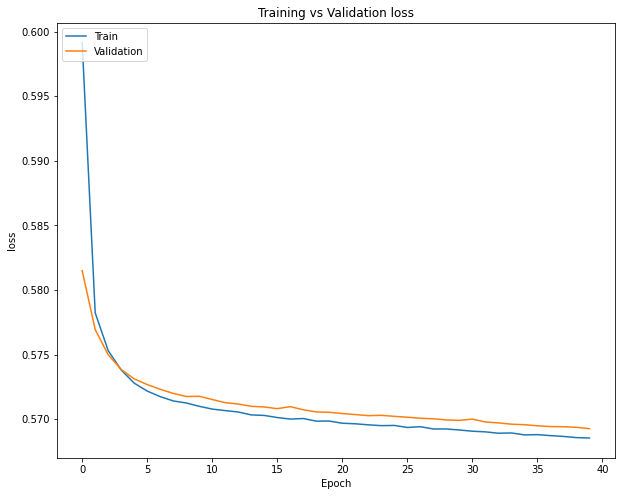

**Training Results**

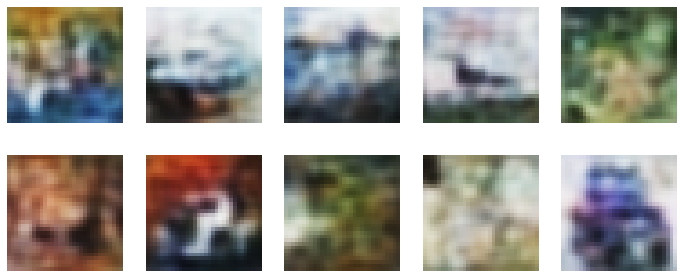

## Model 2

***

***dae_model_2, run #4:***<pre>
*Brief model description goes here.*
*Also what is special about this run.*

**Data**
CIFAR10, img_rows, img_cols, img_ch = 32, 32, 3
num_classes = 10
*Noise: 0.3*

**Hyper parameters**
epochs = 90 # Stopped at 90
batch_size = 256
opt = Adam(lr=0.005, beta_1=0.85, beta_2=0.999, epsilon=1e-07)

**Performance**
Original vs noisy MAE:		 0.20245
Original vs denoised MAE:	 0.05831



**Training History**

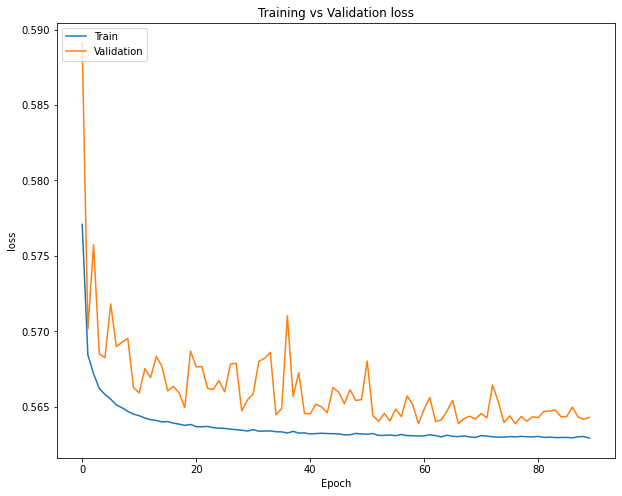

**Training Results**

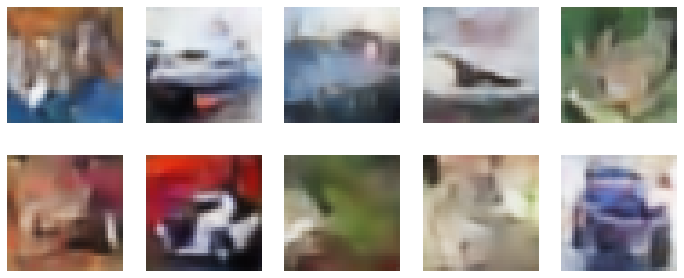

## Model 3

***

***dae_model_3, run #2:***<pre>
*Brief model description goes here.*
*Also what is special about this run.*

**Data**
CIFAR10, img_rows, img_cols, img_ch = 32, 32, 3
num_classes = 10
*Noise: 0.3*

**Hyper parameters**
epochs = 150 # Stopped at 125
batch_size = 512
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

**Performance**
Original vs noisy MAE:		 0.20255
Original vs denoised MAE:	 0.05794

**Training History**

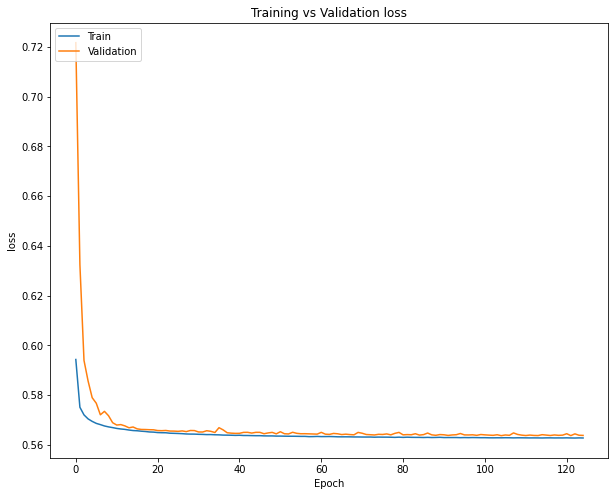

**Testing Results**

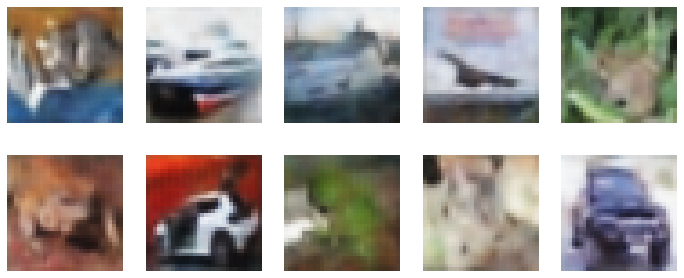

## Model 4

***

***dae_model_4, run #3:***<pre>
*Brief model description goes here.*
*Also what is special about this run.*

**Data**
CIFAR10, img_rows, img_cols, img_ch = 32, 32, 3
num_classes = 10
*Noise: 0.3*

**Hyper parameters**
epochs = 100 # Stopped at 41
batch_size = 128
opt = Adam(lr=0.005, beta_1=0.85, beta_2=0.999, epsilon=1e-07)

**Performance**
Original vs noisy MAE:		 0.20257
Original vs denoised MAE:	 0.06134

**Training history and results**</pre>

***

**Training history**

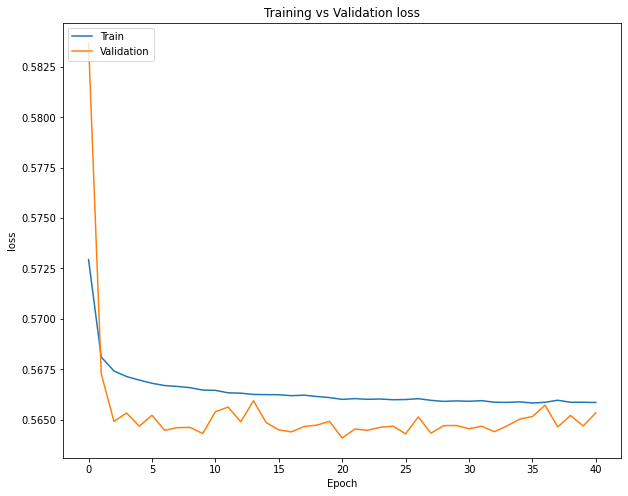

**Training Results**

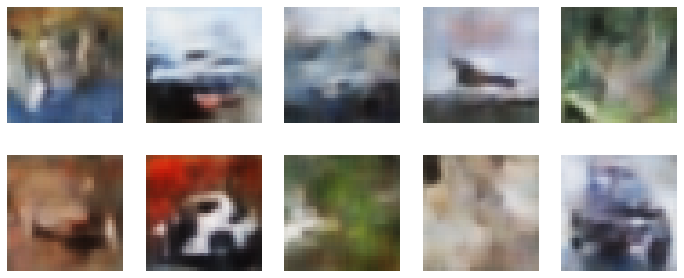

## Model 4 Noise: 0.1

***

***dae_model_4, run #4: Noise Factor = 0.1***<pre>
*Brief model description goes here.*
*Also what is special about this run.*

**Data**
CIFAR10, img_rows, img_cols, img_ch = 32, 32, 3
num_classes = 10
**Noise: 0.1**

**Hyper parameters**
epochs = 100 # Stopped at 56
batch_size = 128
opt = Adam(lr=0.005, beta_1=0.85, beta_2=0.999, epsilon=1e-07)

**Performance**
Original vs noisy MAE:		 0.07647
Original vs denoised MAE:	 0.03708



**Training History**

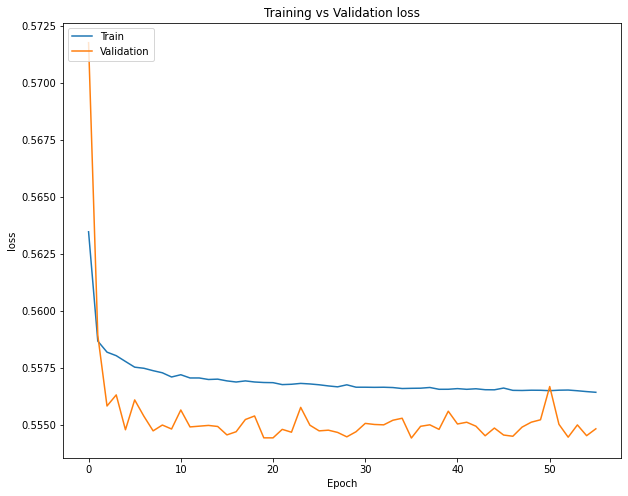

**Testing Results**

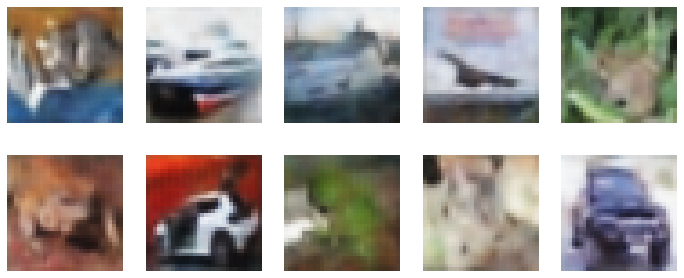